In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv('Trail10k.csv')
test_data = pd.read_csv('Trail1k.csv')

In [3]:
train_data.head(), test_data.head()

(   distance  elevation terrain  dangerous  risk
 0         1          0   paved          0     1
 1         1          0   paved          0     1
 2         1          0   paved          0     1
 3         1          0   paved          0     1
 4         1          0   paved          0     1,
    distance  elevation terrain  dangerous  risk
 0         1          0   paved          0     1
 1         1          0   sandy          0     1
 2         1          0   sandy          0     1
 3         1          0   sandy          0     1
 4         1          0   sandy          0     1)

In [4]:
train_data['dangerous'].value_counts(), test_data['dangerous'].value_counts()

(dangerous
 0    6329
 1    3671
 Name: count, dtype: int64,
 dangerous
 0    639
 1    361
 Name: count, dtype: int64)

## Visualizing Data

In [ ]:
%pip install seaborn matplotlib

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


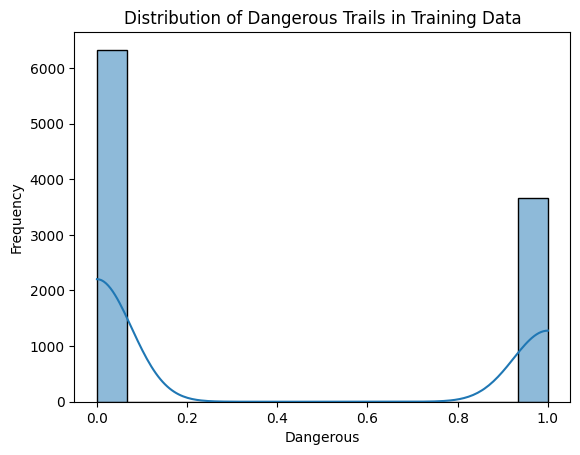

In [13]:
# Distribution of dangerous trails in training data
sns.histplot(train_data['dangerous'], kde=True)
plt.title('Distribution of Dangerous Trails in Training Data')
plt.xlabel('Dangerous')
plt.ylabel('Frequency')
plt.show()

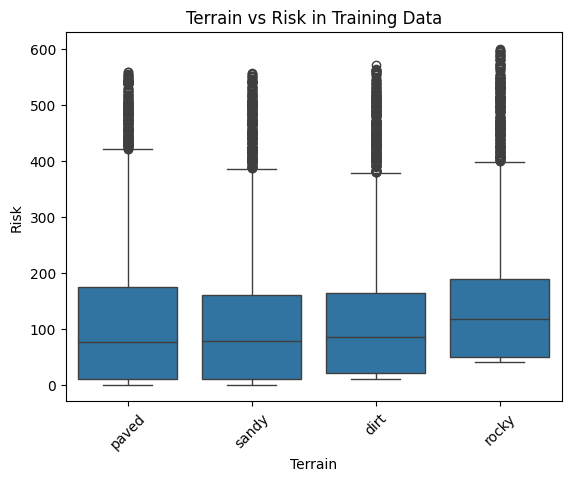

In [14]:
# Boxplot of terrain vs risk
sns.boxplot(x='terrain', y='risk', data=train_data)
plt.title('Terrain vs Risk in Training Data')
plt.xlabel('Terrain')
plt.ylabel('Risk')
plt.xticks(rotation=45)
plt.show()

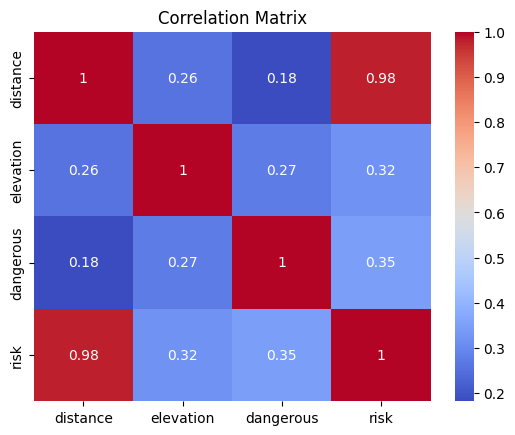

In [16]:
# Correlation heatmap
numeric_cols = train_data.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Step 4: Preprocess for Linear Regression
Linear regression can’t handle text like “sand” or “rocky”, so you need to one-hot encode terrain.

In [17]:
# One-hot encode terrain
train_df_encoded = pd.get_dummies(train_data, columns=['terrain'], drop_first=True)
test_df_encoded = pd.get_dummies(test_data, columns=['terrain'], drop_first=True)

# Align columns in case test is missing any dummy variables
train_df_encoded, test_df_encoded = train_df_encoded.align(test_df_encoded, join='left', axis=1, fill_value=0)

In [18]:
train_df_encoded.head(), test_df_encoded.head()

(   distance  elevation  dangerous  risk  terrain_paved  terrain_rocky  \
 0         1          0          0     1           True          False   
 1         1          0          0     1           True          False   
 2         1          0          0     1           True          False   
 3         1          0          0     1           True          False   
 4         1          0          0     1           True          False   
 
    terrain_sandy  
 0          False  
 1          False  
 2          False  
 3          False  
 4          False  ,
    distance  elevation  dangerous  risk  terrain_paved  terrain_rocky  \
 0         1          0          0     1           True          False   
 1         1          0          0     1          False          False   
 2         1          0          0     1          False          False   
 3         1          0          0     1          False          False   
 4         1          0          0     1          False        

## Step 5: Train a Linear Regression Model

In [19]:
%pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Features and target
X_train = train_df_encoded.drop("risk", axis=1)
y_train = train_df_encoded["risk"]

X_test = test_df_encoded.drop("risk", axis=1)
y_test = test_df_encoded["risk"]

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("R^2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R^2 Score: 0.9999972337798869
MSE: 0.05617867737814669


In [21]:
coeffs = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coeffs)

         Feature  Coefficient
2      dangerous    49.985284
4  terrain_rocky    29.998840
3  terrain_paved   -10.009547
5  terrain_sandy   -10.006219
0       distance     0.999975
1      elevation     0.004925


## Step 6: Test the Model

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate performance
print("R^2 Score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Optional: compare predictions vs actual
results_df = pd.DataFrame({
    'Actual Risk': y_test,
    'Predicted Risk': y_pred
})
print(results_df.head(10))

R^2 Score: 0.9999972337798869
Mean Squared Error: 0.05617867737814669
   Actual Risk  Predicted Risk
0            1        0.863320
1            1        0.866647
2            1        0.866647
3            1        0.866647
4            1        0.866647
5            1        0.866647
6            1        0.866647
7            2        2.340722
8            2        2.340722
9            2        2.340722


## Step 7: Save the Model
Use joblib or pickle. joblib is better for models with NumPy arrays.

In [23]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [24]:
import joblib

# Save model
joblib.dump(model, "trail_risk_model.pkl")

# Save columns used in training (for future input formatting)
joblib.dump(X_train.columns.tolist(), "model_features.pkl")

['model_features.pkl']

## Step: Load the Model and Predict

In [25]:
import joblib
import pandas as pd

# Load model and feature list
model = joblib.load("trail_risk_model.pkl")
feature_columns = joblib.load("model_features.pkl")

# Example new trail input
new_data = pd.DataFrame([{
    "distance": 50,
    "elevation": 200,
    "terrain": "rocky",
    "dangerous": 0
}])

# One-hot encode terrain
new_data_encoded = pd.get_dummies(new_data, columns=["terrain"])

# Align with model’s expected features
new_data_encoded = new_data_encoded.reindex(columns=feature_columns, fill_value=0)

# Predict
predicted_risk = model.predict(new_data_encoded)
print("Predicted Risk:", predicted_risk[0])

Predicted Risk: 90.85540655388031


In [27]:
risk_value = predicted_risk[0]

if risk_value < 75:
    level = "Low Risk"
elif risk_value < 150:
    level = "Moderate Risk"
elif risk_value < 225:
    level = "High Risk"
else:
    level = "Very High Risk"

print(f"Predicted Risk Level: {level} ({risk_value:.0f})")

Predicted Risk Level: Moderate Risk (91)
